# Code to collect images of lego minifigures from https://www.bricklink.com/

## 1. Getting list id's for all Lego themes

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [8]:
import requests
from bs4 import BeautifulSoup
import re

HEADERS = {"User-Agent": "Mozilla/5.0"}
TREE_URL = "https://www.bricklink.com/catalogTree.asp?itemType=M"

def get_all_minifig_category_ids():
    resp = requests.get(TREE_URL, headers=HEADERS)
    soup = BeautifulSoup(resp.text, "html.parser")
    
    category_ids = set()

    for a in soup.find_all("a", href=True):
        match = re.search(r"catString=(\d+)", a['href'])
        if match:
            category_ids.add(match.group(1))

    return sorted(category_ids)

In [9]:
category_ids = get_all_minifig_category_ids()

In [12]:
print(f"Found {len(category_ids)} categories:")
print(category_ids)

Found 119 categories:
['102', '1042', '1043', '1069', '1070', '1095', '1100', '1125', '1154', '1163', '1166', '1197', '1203', '1221', '1227', '1236', '124', '1266', '1268', '1285', '1286', '1305', '1306', '1309', '1312', '153', '155', '157', '166', '167', '170', '174', '179', '227', '273', '277', '284', '294', '34', '36', '390', '447', '449', '469', '473', '48', '482', '490', '516', '53', '537', '54', '545', '548', '563', '568', '570', '572', '573', '574', '605', '608', '609', '61', '617', '62', '629', '65', '67', '689', '69', '732', '733', '734', '746', '747', '748', '749', '755', '757', '759', '761', '764', '768', '771', '78', '781', '787', '789', '790', '795', '801', '804', '807', '815', '817', '822', '842', '843', '85', '850', '856', '860', '868', '870', '876', '878', '893', '9', '918', '920', '925', '927', '957', '965', '971', '975', '976', '983']


## 2. Now using id's to download all minifigures

In [2]:
import os
import re
import time
import requests
from bs4 import BeautifulSoup

HEADERS = {"User-Agent": "Mozilla/5.0"}
BASE_URL = "https://www.bricklink.com/catalogList.asp?catType=M&catString={}"
IMAGE_URL_TEMPLATE = "https://img.bricklink.com/ItemImage/MN/0/{}.png"
SAVE_DIR = "minifigs"

def get_minifig_ids_from_category_page(category_id):
    ids = []
    page = 1
    while True:
        paged_url = BASE_URL.format(category_id) + f"&pg={page}"
        print(paged_url)
        print(f"Parsing page {page} for category {category_id}...")
        resp = requests.get(paged_url, headers=HEADERS)
        soup = BeautifulSoup(resp.text, "html.parser")

        for a in soup.find_all("a", href=True):
            match = re.search(r"catalogitem\.page\?M=([\w\d]+)", a['href'])
            if match:
                minifig_id = match.group(1)
                if minifig_id not in ids:
                    ids.append(minifig_id)

        if not soup.find("a", text="Next"):
            break

        page += 1
        time.sleep(1)
    return ids

def download_minifig_images(minifig_ids, category_id):
    category_path = os.path.join(SAVE_DIR, category_id)
    os.makedirs(category_path, exist_ok=True)

    total = len(minifig_ids)
    print(f"Found {total} minifigs in category {category_id}.")

    for idx, fig_id in enumerate(minifig_ids, start=1):
        filepath = os.path.join(category_path, f"{fig_id}.png")
        if os.path.exists(filepath):
            print(f"Already exists: {fig_id} ({idx}/{total})")
            continue

        img_url = IMAGE_URL_TEMPLATE.format(fig_id)
        print(f"Downloading {fig_id}... {idx}/{total}")
        r = requests.get(img_url, headers=HEADERS)
        if r.status_code == 200:
            with open(filepath, "wb") as f:
                f.write(r.content)
        else:
            print(f"Image not found: {img_url}")


In [73]:
for cat_id in category_ids:
    minifig_ids = get_minifig_ids_from_category_page(cat_id)
    print(f"Found {len(minifig_ids)} minifigs in category {cat_id}.")
    download_minifig_images(minifig_ids, cat_id)

https://www.bricklink.com/catalogList.asp?catType=M&catString=102&pg=1
Parsing page 1 for category 102...


/var/folders/ll/yk8k24ls7ys7l35p4mx8q4100000gn/T/ipykernel_75349/2305530327.py:29: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  if not soup.find("a", text="Next"):


Found 33 minifigs in category 102.
Found 33 minifigs in category 102.
Already exists: 71713 (1/33)
Already exists: 71287 (2/33)
Already exists: 72057 (3/33)
Already exists: 72053 (4/33)
Already exists: 23047c (5/33)
Already exists: 71289b (6/33)
Already exists: 23048 (7/33)
Already exists: 72056 (8/33)
Already exists: 23047b (9/33)
Image not found: https://img.bricklink.com/ItemImage/MN/0/72058.png
Already exists: 71520 (11/33)
Already exists: 72055 (12/33)
Already exists: 23049 (13/33)
Already exists: 71289a (14/33)
Already exists: 71518 (15/33)
Already exists: 22447 (16/33)
Already exists: 71519 (17/33)
Already exists: 23047a (18/33)
Already exists: x4cx02 (19/33)
Already exists: x4cx01 (20/33)
Already exists: scaFemA01 (21/33)
Already exists: scaFemA02 (22/33)
Already exists: scaFemA03 (23/33)
Already exists: scaFemA04 (24/33)
Already exists: scaFemA05 (25/33)
Already exists: scaFemY01 (26/33)
Already exists: scaFemY02 (27/33)
Already exists: scaFemY03 (28/33)
Already exists: scaFem

KeyboardInterrupt: 

## 3. Not all downloaded files are minifigures. 
first deleting all folders with non minifigure themes


36 = Technic
48 = Belville
102 = Scala
153 = Fabuland
155 = Basic
167 = Duplo
273 = BIONICLE
277 = LEGOLAND
294 = Primo
490 = Clikits
516 = 4 Juniors
748 = Cars
749 = Hero factory
771 = Friends
801 = Minecraft
843 = Elves
876 = The Angry Birds Movie
893 = DC Super Hero Girls
965 = Unikitty!
1069 = Trolls World Tour
1070 = Despicable Me and Minions
1095 = Super Mario
1166 = Games
1266 = Gabby's Dollhouse
1285 = Animal Crossing
1305 = Wicked
1312 = Wednesday

using YOLO to detect torso on image. First labeling 500 random minifigures for torso detection

In [80]:
import os
import random
import shutil

minifigs_dir = "minifigs"
output_dir = "torsos"
os.makedirs(output_dir, exist_ok=True)

all_fig_paths = []
for root, dirs, files in os.walk(minifigs_dir):
    for file in files:
        if file.endswith(".png"):
            all_fig_paths.append(os.path.join(root, file))

sample_paths = random.sample(all_fig_paths, min(500, len(all_fig_paths)))

for src_path in sample_paths:
    filename = os.path.basename(src_path)
    dst_path = os.path.join(output_dir, filename)
    shutil.copy(src_path, dst_path)

print(f"‚úÖ Copied {len(sample_paths)} images to {output_dir}")


‚úÖ Copied 500 images to torso2


# 4. training YOLOv5 for torso recognition

## Installing YOLO

In [85]:
#!git clone https://github.com/ultralytics/yolov5

In [87]:
!cd yolov5

In [89]:
pip install -r yolov5/requirements.txt

  Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_x86_64.whl.metadata (20 kB)
  Using cached torch-2.2.2-cp310-none-macosx_10_9_x86_64.whl.metadata (25 kB)
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 56.7/56.7 MB 41.6 MB/s eta 0:00:0000:0100:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.7/1.7 MB 28.2 MB/s eta 0:00:00
Using cached torch-2.2.2-cp310-none-macosx_10_9_x86_64.whl (150.8 MB)
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.0/1.0 MB 23.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1
    Uninstalling torch-2.5.1:
      Successfully uninstalled torch-2.5.1
Note: you may need to restart the kernel to use updated packages.


## Getting files ready to train YOLOv5

In [90]:
import os

base = "lego-torso-yolo"
for split in ["train", "val"]:
    os.makedirs(os.path.join(base, "images", split), exist_ok=True)
    os.makedirs(os.path.join(base, "labels", split), exist_ok=True)

In [91]:
import os
import xml.etree.ElementTree as ET

IMG_DIR = "torsos"
LABEL_OUT_DIR = "yolo_labels"
os.makedirs(LABEL_OUT_DIR, exist_ok=True)

for file in os.listdir(IMG_DIR):
    if file.endswith(".xml"):
        tree = ET.parse(os.path.join(IMG_DIR, file))
        root = tree.getroot()
        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        output_lines = []
        for obj in root.findall("object"):
            if obj.find("name").text != "torso":
                continue

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            xmax = int(bbox.find("xmax").text)
            ymin = int(bbox.find("ymin").text)
            ymax = int(bbox.find("ymax").text)

            x_center = ((xmin + xmax) / 2) / w
            y_center = ((ymin + ymax) / 2) / h
            width = (xmax - xmin) / w
            height = (ymax - ymin) / h

            output_lines.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        if output_lines:
            name = os.path.splitext(file)[0]
            with open(os.path.join(LABEL_OUT_DIR, name + ".txt"), "w") as f:
                f.write("\n".join(output_lines))

In [92]:
import os
import shutil
import random

img_dir = "torsos"
label_dir = "yolo_labels"
out_img = "lego-torso-yolo/images"
out_lbl = "lego-torso-yolo/labels"
os.makedirs(out_img + "/train", exist_ok=True)
os.makedirs(out_img + "/val", exist_ok=True)
os.makedirs(out_lbl + "/train", exist_ok=True)
os.makedirs(out_lbl + "/val", exist_ok=True)

all_files = [f for f in os.listdir(img_dir) if f.endswith(".png") and os.path.exists(os.path.join(label_dir, f.replace(".png", ".txt")))]
random.shuffle(all_files)
split = int(len(all_files) * 0.8)

for i, fname in enumerate(all_files):
    name = os.path.splitext(fname)[0]
    if i < split:
        part = "train"
    else:
        part = "val"
    shutil.copy(os.path.join(img_dir, fname), f"{out_img}/{part}/{fname}")
    shutil.copy(os.path.join(label_dir, name + ".txt"), f"{out_lbl}/{part}/{name}.txt")


In [93]:
data_yaml_content = """train: ../lego-torso-yolo/images/train
val: ../lego-torso-yolo/images/val

nc: 1
names: ['torso']
"""

output_path = "lego-torso-yolo/data.yaml"
with open(output_path, "w", encoding="utf-8") as f:
    f.write(data_yaml_content)

output_path


'lego-torso-yolo/data.yaml'

## Training YOLOv5 (in terminal)

python train.py --img 416 --batch 16 --epochs 50 --data ../lego-torso-yolo/data.yaml --weights yolov5s.pt --name lego_torso

In [ ]:
python train.py --img 768 --batch 32 --epochs 100 --data ../lego-torso-yolo/data.yaml --weights yolov5s.pt --name lego_torso_768 --cache

In [1]:
#import torch
#print(torch.__version__)
#print("CUDA available:", torch.cuda.is_available())
#print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

2.5.1+cu121
CUDA available: True
Device: NVIDIA GeForce RTX 4090


Weights are stored in yolov5\runs\train\lego_torso_768\weights\best.pt

Example of recognition

<img src="yolov5\runs\train\lego_torso_768\val_batch1_pred.jpg" width="400" height="200">

# 5. Using YOLOv5 to determine if there is a minifigure on a photo, 
## then removing background with Rembg and splitting minifigure into head/torso/legs

In [63]:
#!pip install rembg

In [2]:
import torch
import numpy as np
import cv2
from PIL import Image
from rembg import remove
import io

In [3]:
test_img_minifig = 'minifigs\\34\\ac001.png' #minifigure
test_img_not_minifig =  'minifigs\\170\\alp007.png' #not minifigure

In [4]:
# loading model globally
yolo_model = torch.hub.load(
    'yolov5',
    'custom',
    path='yolov5\\runs\\train\\lego_torso_768\\weights\\best.pt',
    source='local'
)
def is_minifigure(img):
    if isinstance(img, str):
        img = Image.open(img).convert("RGB")
    results = yolo_model(img)
    detections = results.xyxy[0]  # x1, y1, x2, y2, conf, class
    return len(detections) > 0

YOLOv5  v7.0-418-ga493afe1 Python-3.12.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [5]:
def remove_background(img_path):
    with open(img_path, "rb") as f:
        input_image = f.read()
    output_image = remove(input_image)
    return Image.open(io.BytesIO(output_image)).convert("RGBA")
    
def remove_misc_only_largest(pil_img):
    img_rgba = np.array(pil_img)
    alpha = img_rgba[:, :, 3]

    # –ë–∏–Ω–∞—Ä–∏–∑—É–µ–º –∞–ª—å—Ñ–∞-–∫–∞–Ω–∞–ª
    mask = (alpha > 10).astype(np.uint8) * 255

    # –ù–∞–π—Ç–∏ –≤—Å–µ —Å–≤—è–∑–∞–Ω–Ω—ã–µ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã (–∫–æ–Ω—Ç—É—Ä—ã)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

    if num_labels <= 1:
        return pil_img

    # –ù–∞—Ö–æ–¥–∏–º –∫–æ–º–ø–æ–Ω–µ–Ω—Ç —Å –Ω–∞–∏–±–æ–ª—å—à–µ–π –ø–ª–æ—â–∞–¥—å—é (–ø—Ä–æ–ø—É—Å–∫–∞–µ–º label=0 ‚Äî —Ñ–æ–Ω)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    # –°–æ–∑–¥–∞—ë–º –º–∞—Å–∫—É —Ç–æ–ª—å–∫–æ –¥–ª—è —Å–∞–º–æ–π –∫—Ä—É–ø–Ω–æ–π –æ–±–ª–∞—Å—Ç–∏
    largest_mask = (labels == largest_label).astype(np.uint8) * 255

    # –ü—Ä–∏–º–µ–Ω—è–µ–º –º–∞—Å–∫—É –∫ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—é
    result_rgba = cv2.bitwise_and(img_rgba, img_rgba, mask=largest_mask)

    # –û–±–Ω—É–ª—è–µ–º –ø–∏–∫—Å–µ–ª–∏ –≤–Ω–µ –æ–±–ª–∞—Å—Ç–∏ (–¥–µ–ª–∞–µ–º –∏—Ö –ø—Ä–æ–∑—Ä–∞—á–Ω—ã–º–∏)
    result_rgba[largest_mask == 0] = [0, 0, 0, 0]

    return Image.fromarray(result_rgba)
        
def img_process(img_path):
    if not is_minifigure(img_path):
        print("not minifigure - skipping")
        return None
    print("processing")
    img_no_bg = remove_background(img_path)
    final = remove_misc_only_largest(img_no_bg)
    return final

In [12]:
test_path = 'minifigs\\34\\ac001.png'
test_path_misc = 'minifigs\\868\\nex004.png'
test_path_bg = 'minifigs\\9\\cas253.png'

processing


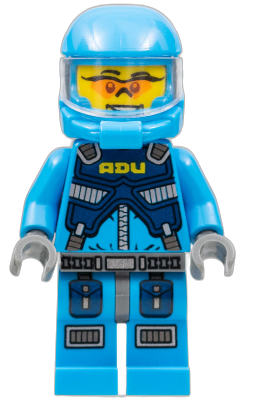

In [13]:
img_process(test_path)

processing


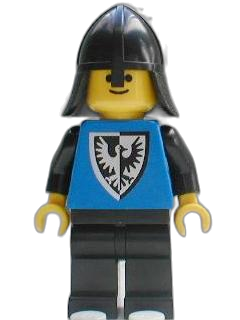

In [14]:
img_process(test_path_bg)

processing


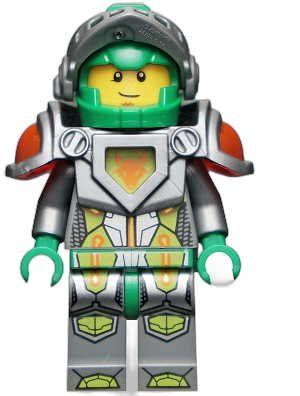

In [15]:
img_process(test_path_misc)

## Now we need to split minifigure into head/torso/legs

In [6]:
from PIL import ImageDraw

def draw_torso_box(pil_img):
    # getting predictions
    results = yolo_model(pil_img)
    detections = results.xyxy[0]

    if len(detections) == 0:
        return pil_img 

    # copy image for drawing
    img_with_box = pil_img.copy()
    draw = ImageDraw.Draw(img_with_box)

    for det in detections:
        x1, y1, x2, y2, conf, cls = det.tolist()
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.text((x1, y1 - 10), f"torso {conf:.2f}", fill="red")

    return img_with_box

In [17]:
test = img_process(test_path)

processing


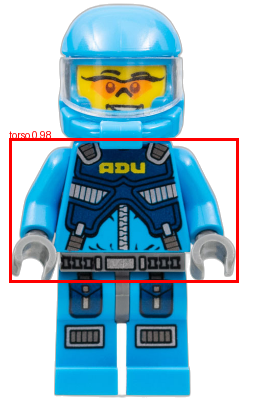

In [18]:
draw_torso_box(test)

In [7]:
def split_minifigure(pil_img, name):
    results = yolo_model(pil_img)
    detections = results.xyxy[0]

    if len(detections) == 0:
        print("no torso - skipping")
        return
    best = detections[0]
    x1, y1, x2, y2 = map(int, best[:4])
    w, h = pil_img.size

    y1 = max(0, y1)
    y2 = min(h, y2)

    # cutting head / torso / legs
    head_region = pil_img.crop((0, 0, w, y1))
    torso_region = pil_img.crop((0, y1, w, y2))
    legs_region = pil_img.crop((0, y2, w, h))

    # saving
    head_region.save(f"head_{name}")
    torso_region.save(f"torso_{name}")
    legs_region.save(f"legs_{name}")

    print(f"‚úÖ saved: head_{name}, torso_{name}, legs_{name}")

In [55]:
split_minifigure(test, 'test.png')

‚úÖ saved: head_test.png, torso_test.png, legs_test.png


C:\Users\user\Desktop\GitHub\lego_project\data_set_collection\yolov5\models\common.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


## Making final function for img processing

In [8]:
import os
from PIL import Image

def img_process(img_path):
    # Extract the image name without extension
    name = os.path.splitext(os.path.basename(img_path))[0]

    if not is_minifigure(img_path):
        print(f"‚ùå [{name}] No torso detected ‚Äî skipping")
        return "no_torso"

    print(f"‚úÖ [{name}] Torso detected ‚Äî processing...")

    # Step 1: Remove background
    img_no_bg = remove_background(img_path)

    # Step 2: Keep only the largest component (main figure)
    main_fig = remove_misc_only_largest(img_no_bg)

    # Step 3: Detect torso with YOLO
    results = yolo_model(main_fig)
    detections = results.xyxy[0]

    if len(detections) == 0:
        print(f"‚ö†Ô∏è [{name}] Torso not detected after cleanup ‚Äî skipping")
        return

    # Step 4: Get bounding box of the detected torso
    x1, y1, x2, y2 = map(int, detections[0][:4])
    w, h = main_fig.size

    # Step 5: Split the image
    head_region = main_fig.crop((0, 0, w, y1))
    torso_region = main_fig.crop((0, y1, w, y2))
    legs_region = main_fig.crop((0, y2, w, h))

    # Step 6: Create output folders inside 'data_set'
    os.makedirs("data_set/head", exist_ok=True)
    os.makedirs("data_set/torso", exist_ok=True)
    os.makedirs("data_set/legs", exist_ok=True)

    # Step 7: Save the parts
    head_region.save(f"data_set/head/head_{name}.png")
    torso_region.save(f"data_set/torso/torso_{name}.png")
    legs_region.save(f"data_set/legs/legs_{name}.png")

    print(f"üíæ [{name}] Saved to data_set")
    return "ok"

In [21]:
img_process(test_img_minifig)

‚úÖ [ac001] Torso detected ‚Äî processing...
üíæ [ac001] Saved to data_set


'ok'

# 6. Now prepairing data set for spliting minifigures into head/torso/legs 

In [9]:
import os
import shutil
import time

def format_time(seconds):
    mins, secs = divmod(int(seconds), 60)
    return f"{mins}m {secs}s"

def process_all_minifigs(root_dir="minifigs"):
    # Step 1: gather all .png files
    all_files = []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(".png"):
                full_path = os.path.join(subdir, file)
                all_files.append(full_path)

    total = len(all_files)
    print(f"üîç Found {total} images to process.")

    start_time = time.time()
    processed = 0

    # Step 2: processing loop
    for idx, path in enumerate(all_files, start=1):
        name = os.path.splitext(os.path.basename(path))[0]
        head_output = f"data_set/head/head_{name}.png"

        if os.path.exists(head_output):
            print(f"‚è© [{idx}/{total}] Skipped {name} ‚Äî already processed")
            continue

        print(f"üîß [{idx}/{total}] Processing: {name}", end="")

        t0 = time.time()
        try:
            result = img_process(path)
            if result == "no_torso":
                os.makedirs("ignored_minifigures", exist_ok=True)
                shutil.copy(path, os.path.join("ignored_minifigures", f"{name}.png"))
                print(" ‚Üí saved to ignored_minifigures")
            else:
                print(" ‚úì done")
        except Exception as e:
            print(f" ‚ùå failed ‚Äî {e}")
            continue

        processed += 1
        elapsed = time.time() - start_time
        avg_time = elapsed / processed
        remaining = avg_time * (total - idx)

        print(f" ‚è≥ ETA: {format_time(remaining)}")


In [10]:
process_all_minifigs()

üîç Found 14120 images to process.
‚è© [1/14120] Skipped hs001 ‚Äî already processed
‚è© [2/14120] Skipped hs002 ‚Äî already processed
‚è© [3/14120] Skipped hs003 ‚Äî already processed
‚è© [4/14120] Skipped hs004 ‚Äî already processed
‚è© [5/14120] Skipped hs005 ‚Äî already processed
‚è© [6/14120] Skipped hs006 ‚Äî already processed
‚è© [7/14120] Skipped hs007 ‚Äî already processed
‚è© [8/14120] Skipped hs008 ‚Äî already processed
‚è© [9/14120] Skipped hs009 ‚Äî already processed
‚è© [10/14120] Skipped hs010 ‚Äî already processed
‚è© [11/14120] Skipped hs011 ‚Äî already processed
‚è© [12/14120] Skipped hs012 ‚Äî already processed
‚è© [13/14120] Skipped hs013 ‚Äî already processed
‚è© [14/14120] Skipped hs014 ‚Äî already processed
‚è© [15/14120] Skipped hs015 ‚Äî already processed
‚è© [16/14120] Skipped hs016 ‚Äî already processed
‚è© [17/14120] Skipped hs017 ‚Äî already processed
‚è© [18/14120] Skipped hs018 ‚Äî already processed
‚è© [19/14120] Skipped hs019 ‚Äî already processed
‚è© 

# 7. Files are processed. Next step is embedding